In [46]:
from langdetect import detect
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import numpy as np



def detectar_idioma(texto):
    try:
        return detect(texto)
    except:
        return "desconocido"

def filtrar_idioma(df):

    df["idioma_detectado"] = df["review_es"].apply(detectar_idioma)

    return df[df["idioma_detectado"] == "es"]

def normalizar_texto(df, columna):
    reemplazos = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"}
    df[columna] = df[columna].str.lower()
    for clave, valor in reemplazos.items():
        df[columna] = df[columna].str.replace(clave, valor)
    return df[columna]

def reemplazar_no(df):
    def reemplazo(texto):
        if isinstance(texto, str):
            return texto.replace(" película ", "")
        return texto

    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].apply(reemplazo)

    return df

def imprimir_resultados(y, y_pred):

    labels = [0, 1]

    f1 = f1_score(y, y_pred, pos_label=0, labels=labels)
    precision = precision_score(y, y_pred, pos_label=0, labels=labels)
    recall = recall_score(y, y_pred, pos_label=0, labels=labels)
    accuracy = accuracy_score(y, y_pred)

    cm = confusion_matrix(y, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

def guardar_resultado_en_csv(prediccion, df_test, ruta):

    prediccion = np.where(prediccion == 0, "negativo", "positivo")

    df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": prediccion})

    df_predicciones.to_csv(ruta, header=["ID", "sentimiento"], index=False)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
RUTA_TRAIN = "drive/MyDrive/train_limpio.csv"
RUTA_TEST = "drive/MyDrive/test.csv"

In [50]:
df_train = pd.read_csv(RUTA_TRAIN)
df_test = pd.read_csv(RUTA_TEST)

In [51]:
df_train["sentimiento"] = df_train["sentimiento"].map({"positivo": 1, "negativo": 0})

In [52]:
RUTA_GUARDADO = "RED.csv"

In [53]:
df_train.head(5)

,Unnamed: 0,ID,review_es,sentimiento,idioma_detectado
0,0,0,Uno de los otros críticos ha mencionado que de...,1,es
1,1,1,Una pequeña pequeña producción.La técnica de f...,1,es
2,2,2,Pensé que esta era una manera maravillosa de p...,1,es
3,3,3,"Básicamente, hay una familia donde un niño peq...",0,es
4,4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",1,es


In [54]:
total_reviews = df_train["review_es"].astype(str)
total_labels = df_train["sentimiento"].values

In [55]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Entrenamiento")
    plt.plot(history.history["val_accuracy"], label="Validación")
    plt.title("Precisión del Modelo")
    plt.xlabel("Épocas")
    plt.ylabel("Precisión")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Entrenamiento")
    plt.plot(history.history["val_loss"], label="Validación")
    plt.title("Pérdida del Modelo")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.legend()

    plt.show()

In [56]:
Y_data = df_train.sentimiento

In [57]:
max_words = 5000
max_len = 100

In [58]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [59]:
tokenizer_obj = Tokenizer(num_words = max_words)
tokenizer_obj.fit_on_texts(total_reviews)

In [60]:
X_data_tokens = tokenizer_obj.texts_to_sequences(total_reviews)

In [61]:
X_data_count = tokenizer_obj.sequences_to_matrix(X_data_tokens, mode = "count")

In [62]:
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X_data_count, Y_data, test_size = 0.3, random_state = 123)

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorboard.plugins.hparams import api as hp
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Definir early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Ejemplo de ModelCheckpoint para guardar el mejor modelo
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Ejemplo de ReduceLROnPlateau para ajustar la tasa de aprendizaje
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.005)

callbacks = [early_stopping, reduce_lr]


In [64]:
model_count = Sequential()
model_count.add(Dense(600, activation="relu", input_shape=(5000,)))
model_count.add(Dense(35, activation="relu"))
model_count.add(Dense(1, activation="sigmoid"))

model_count.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [65]:
history_count = model_count.fit(X_train_count, y_train_count, batch_size = 256, epochs = 1, validation_split=0.3,callbacks=callbacks)

93/93 [==============================] - 12s 121ms/step - loss: 0.3958 - accuracy: 0.8284 - val_loss: 0.3457 - val_accuracy: 0.8600 - lr: 0.0010


In [66]:
test_loss, test_acc = model_count.evaluate(X_test_count, y_test_count)
print()
print(test_loss, test_acc)

452/452 [==============================] - 4s 8ms/step - loss: 0.3453 - accuracy: 0.8669

0.3453207314014435 0.8668972849845886


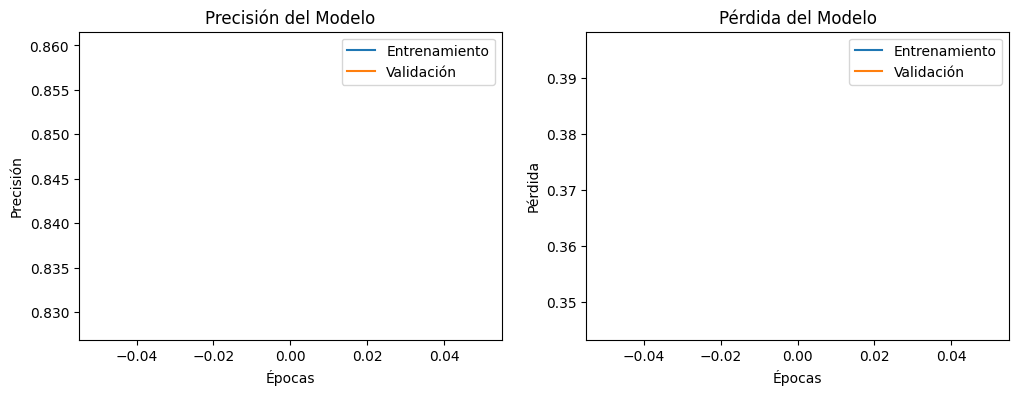

In [67]:
plot_training_history(history_count)

In [68]:
X_train_tokens = tokenizer_obj.texts_to_sequences(df_test["review_es"])
X_train_count = tokenizer_obj.sequences_to_matrix(X_train_tokens, mode = "count")
y_pred = model_count.predict(X_test_count)
y_pred = np.round(y_pred)

452/452 [==============================] - 4s 9ms/step


F1: 0.8580073800738007
Precision: 0.9219666931007138
Recall: 0.8023464458247067
Accuracy: 0.8668972673815288


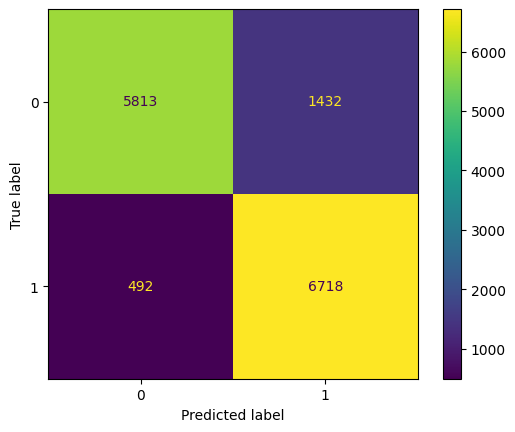

In [69]:
imprimir_resultados(y_test_count, y_pred)

In [70]:
X_test_tokens = tokenizer_obj.texts_to_sequences(df_test["review_es"])
X_test_count = tokenizer_obj.sequences_to_matrix(X_test_tokens, mode = "count")
y_pred = model_count.predict(X_test_count)
y_pred = np.round(y_pred)

269/269 [==============================] - 2s 7ms/step


In [71]:
y_pred

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [72]:
y_pred = np.where(y_pred == 0, "negativo", "positivo")

In [73]:
df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": y_pred.flatten()})

df_predicciones.to_csv(RUTA_GUARDADO, header=["ID", "sentimiento"], index=False)